In [1]:
import numpy as np
import matplotlib.pyplot as plt

from math import ceil, floor
from scipy.optimize import minimize
from tqdm import tqdm
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from clusterlensing import ClusterLensing
from astropy.cosmology import FlatLambdaCDM
import pandas as pd

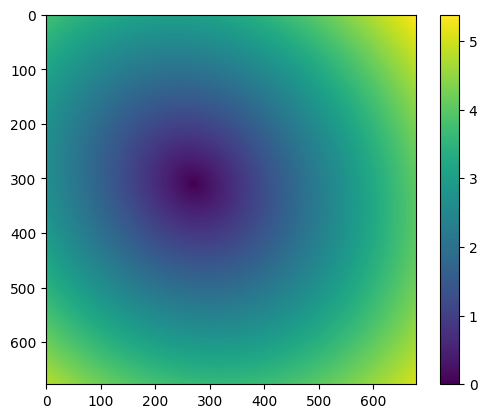

In [2]:

# specify the choice of lens models #
lens_model_list = ['SIE']

# setup lens model class with the list of lens models #
lensModel = LensModel(lens_model_list=lens_model_list)

# define parameter values of lens models #
theta_E = 100                 #in pixel
len_coord = (270, 310)        #in pixel
kwargs_sie = {'theta_E': theta_E, 'e1':0, 'e2':0.2, 'center_x': len_coord[0], 'center_y': len_coord[1]}
kwargs_lens = [kwargs_sie]

# image plane coordinate #
size = 678
pixscale = 0.01
x_grid, y_grid = np.meshgrid(np.linspace(0, size-1, size), np.linspace(0, size-1, size))

# Flatten the grid for calculations
x_flat = x_grid.flatten()
y_flat = y_grid.flatten()

# Calculate convergence (kappa)
kappa = lensModel.kappa(x_flat, y_flat, kwargs_lens)

# Reshape back to 2D grid
#kappa_2d = kappa.reshape(x_grid.shape)

# ray-tracing to the source plane

alpha_x, alpha_y = lensModel.alpha(x_flat, y_flat, kwargs_lens)
# make beta_x and beta_y 2d

alpha_x_2d = alpha_x.reshape(x_grid.shape)
alpha_y_2d = alpha_y.reshape(x_grid.shape)
alpha_x_arcsec = alpha_x_2d * pixscale
alpha_y_arcsec = alpha_y_2d * pixscale

psi = lensModel.potential(x_flat, y_flat, kwargs_lens)
psi = psi.reshape(x_grid.shape)
psi_arcsec = psi * pixscale**2


plt.imshow(psi_arcsec)   #assume this is in arcsec
plt.colorbar()

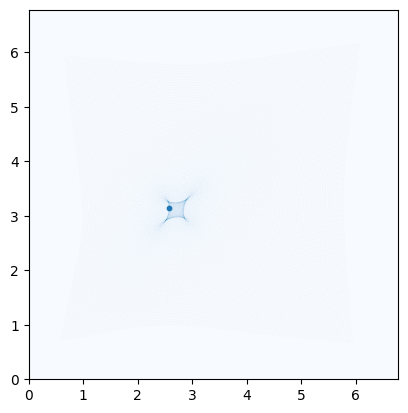

In [8]:
# illustrate the casutic
array_test = np.zeros([678,678])

for i in range(0, 678):
    for j in range(0, 678):
        ycoord = i-alpha_y_2d[i,j] # src coord
        xcoord = j-alpha_x_2d[i,j]
        if ycoord<0 or ycoord>677 or xcoord<0 or xcoord>677:
            continue
        xceil = ceil(xcoord)
        yceil = ceil(ycoord)
        xfloor = floor(xcoord)
        yfloor = floor(ycoord)
        if i%3==0 and j%3==0:
            array_test[yfloor,xfloor] += 1 
      
    
plt.imshow(array_test, cmap='Blues', extent=[0, 678* pixscale, 678* pixscale, 0])
plt.gca().invert_yaxis()

# define source position
beta_x, beta_y = 2.5673469387755103, 3.1510204081632653
plt.scatter(beta_x, beta_y, s =10)

In [9]:
x_grid = np.linspace(0, size-1, size)
x_grid = x_grid * pixscale

In [10]:
# Assuming deflection maps are stored in alpha_x_map and alpha_y_map
# and that they are on a grid defined by x_grid and y_grid

# Set up the interpolated lens model
lens_model_list1 = ['INTERPOL']
kwargs_lens1 = [{'grid_interp_x': x_grid, 'grid_interp_y': x_grid, 'f_': psi_arcsec,
                          'f_x': alpha_x_arcsec, 'f_y': alpha_y_arcsec}]

lensModel_interpol = LensModel(lens_model_list=lens_model_list1)


# Use lens equation solver
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
solver1 = LensEquationSolver(lensModel_interpol)

# my code
z_s = 1.0
z_l = 0.5
cluster = ClusterLensing(alpha_x_arcsec, alpha_y_arcsec, psi_arcsec, z_l , z_s, pixscale, 678, diff_z = True)

In [11]:
kwargs_mp = {'theta_E': theta_E* pixscale, 'e1':0, 'e2':0.2, 'center_x': len_coord[0]* pixscale, 'center_y': len_coord[1]* pixscale}
kwargs_lens = [kwargs_mp]
solver = LensEquationSolver(lensModel)

# SIE model first guess (Checked, same as INTERPOL first guess)
possible_solutions_analytical = solver.candidate_solutions(beta_x, beta_y, kwargs_lens,verbose= True)
print(possible_solutions_analytical)

# SIE model solution
real_sol = solver.image_position_from_source(beta_x, beta_y, kwargs_lens)
print(real_sol)

#INTERPOL model solution
real_sol_interpol = solver1.image_position_from_source(beta_x, beta_y, kwargs_lens1)
print(real_sol_interpol)




(array([2.75, 3.05, 3.45, 1.75]), array([2.15, 2.25, 3.45, 3.85]), array([0.0105647 , 0.02551845, 0.01507356, 0.0263295 ]), 0.09999999999999964)
(array([1.73874247, 3.47098526]), array([3.79923508, 3.43336961]))
(array([1.73874608, 3.47096802]), array([3.79923588, 3.43336879]))


In [14]:
# My code first guess
possible_sol_approx = cluster.find_rough_def_pix(beta_x/pixscale, beta_y/pixscale)
print(possible_sol_approx)

# My code clustering
clustering = cluster.clustering(beta_x/pixscale, beta_y/pixscale)
print(len(clustering))

# My code solution
real_sol_approx = cluster.get_image_positions(beta_x, beta_y)
print(real_sol_approx)

[(260, 216), (261, 216), (262, 216), (263, 216), (264, 216), (265, 216), (266, 216), (267, 216), (268, 216), (269, 216), (270, 216), (271, 216), (272, 216), (273, 216), (274, 216), (275, 216), (276, 216), (277, 216), (278, 216), (279, 216), (280, 216), (281, 216), (279, 217), (280, 217), (281, 217), (282, 217), (283, 217), (284, 217), (285, 217), (286, 217), (287, 217), (287, 218), (288, 218), (289, 218), (290, 218), (291, 218), (292, 219), (293, 219), (294, 219), (348, 342), (347, 343), (347, 344), (173, 379), (174, 379), (174, 380), (174, 381), (175, 381)]
3
[(1.7387460781423822, 3.7992358802936987), (2.7500000000227702, 2.1605779935579057), (3.4709680173772046, 3.433368793637905)]


In [ ]:
cluster.ray_trace_and_print_distances(beta_x/pixscale, beta_y/pixscale)

[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745, 1.0), (0.21568627450980393, 0.49411764705882355, 0.7215686274509804, 1.0)]


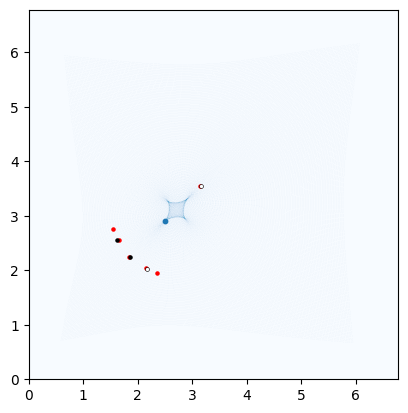

In [18]:
plt.imshow(array_test, cmap='Blues', extent=[0, 678* pixscale, 678* pixscale, 0])
plt.gca().invert_yaxis()

plt.scatter(beta_x, beta_y, s = 10)

plt.scatter(possible_solutions_analytical[0], possible_solutions_analytical[1], s=5, c='r')
#plt.scatter(real_sol[0], real_sol[1], s=5, c='y')
plt.scatter(real_sol_interpol[0], real_sol_interpol[1], s=5, c='k')


cmap = plt.colormaps.get_cmap('Set1')
colors = [cmap(i) for i in range(len(clustering))]
print(colors)
'''
for i in range(0, len(clustering)):
    color = colors[i]
    for j in range(0, len(clustering[i])):
        plt.scatter(clustering[i][j][0]* pixscale, clustering[i][j][1]*pixscale, s=5, c = color)
'''

#for i in range(0, len(possible_sol_approx)):
    #plt.scatter(possible_sol_approx[i][0]*pixscale, possible_sol_approx[i][1]*pixscale, s=5, c = 'g')
for i in range(0, len(real_sol_approx)):
    plt.scatter(real_sol_approx[i][0], real_sol_approx[i][1], s=2, c = 'w')

In [13]:
wrong_img = (2.7500000000366214/pixscale, 2.1605762091041427/pixscale)
diff = cluster.diff_interpolate(wrong_img, beta_x/pixscale, beta_y/pixscale)
print(diff)

0.02904754773504658
